# Cats vs dogs. Transfer learning.
## A binary classifier (either cat or dog) is used.
## This shows how to use transfer learning
### Keras and VGG16 will be used

In [132]:
# Lets import some stuff
import tensorflow as tf
from skimage import io
from IPython.display import Image
from PIL import Image as PILImage
import pandas as pd

#from skimage.transform import resize
import matplotlib.pyplot as plt
from os import listdir
from os import mkdir
from skimage.io import imsave
import numpy as np
from sklearn.utils import shuffle
import sys
#import os
import cv2
%matplotlib inline

In [32]:
FLOYDHUB=False
if FLOYDHUB:
    OUTPUT_DIR = "/output/"
    DATA_DIR = "/input/"
    CLEANED_DATA_DIR = "/input/"
else:
    OUTPUT_DIR = "/tmp/"
    DATA_DIR = "data/train/"
    CLEANED_DATA_DIR = "data/augmented/"



### Explore the dataset

The definition of kaggle dataset is 

"The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat)."

Notice! your direcory should look like this (once you have uncompressed the data)
```
.
├── cats-vs-dogs.ipynb
└── data
    └── train [25000 entries exceeds filelimit, not opening dir]
            ├── cat.2976.jpg
            ├── dog.2977.jpg
            ├── cat.2978.jpg
            ├── dog.2979.jpg
            ├── ...

```
Of course images named cat.xxx.jpg are cats and thesame goes for the ones started with dogs.

Lets open a few images


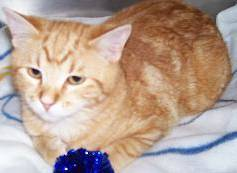

In [131]:
Image(filename=DATA_DIR+'cat.42.jpg')


In [34]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
def resize_and_pad(img, size, padColor=0):
    # Credits goes to 
    # https://stackoverflow.com/questions/44720580/resize-image-canvas-to-maintain-square-aspect-ratio-in-python-opencv
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, 
                                    pad_left, pad_right, 
                                    borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [35]:
original = cv2.imread(DATA_DIR+'cat.42.jpg')
resized = resize_and_pad(original, (IMAGE_HEIGHT, IMAGE_WIDTH))
print(resized.shape)

(128, 128, 3)


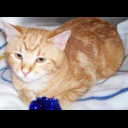

In [36]:
PILImage.fromarray(resized)

In [37]:
def convert_images(limit=None, data_dir=DATA_DIR, cleaned_data_dir=CLEANED_DATA_DIR):
    try:
        mkdir(cleaned_data_dir)
    except:
        pass
    
    i = 1
    for image_file in listdir(data_dir):
        if ".jpg" in image_file:
            original = cv2.imread(data_dir+image_file)
            transformed = resize_and_pad(original, (IMAGE_WIDTH, IMAGE_HEIGHT))
            final_file = cleaned_data_dir+image_file
            imsave(final_file, transformed)
            if i % 500 == 0:
                print("Converted ", i, " images so far...")
            i += 1
        if limit and i > limit:
            break
    print("Done!")

In [38]:
if False:
    convert_images(3000)

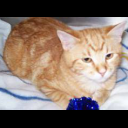

In [39]:
mirrored_image = cv2.flip(resized,1)
PILImage.fromarray(mirrored_image)

In [40]:
def augment_data():
    i = 0
    for image_file in listdir(CLEANED_DATA_DIR):
        original = cv2.imread(CLEANED_DATA_DIR + image_file)
        augmented_image = cv2.flip(original,1)
        final_file = CLEANED_DATA_DIR + image_file
        final_file = final_file.replace(".jpg", ".augmented.jpg")
        #print(final_file)
        imsave(final_file, augmented_image)
        i += 1
        if i % 250 == 0:
            print("Converted %d images so far..." % i)
if False:
    augment_data()

In [235]:
CAT_LABEL = 0
DOG_LABEL = 1

import os.path


def load_raw_image(my_file, cleaned_data_dir):
    expected_shape = (128, 128, 3)
    if (os.path.isfile(cleaned_data_dir+my_file)):
        raw_image = io.imread(cleaned_data_dir+my_file)
        if raw_image.shape != expected_shape:
            print(cleaned_data_dir+my_file, "=>", raw_image.shape)
            return None
        else:
            return raw_image
    else:
        return None

def load_data(load_from=0, load_to=1000, cleaned_data_dir=CLEANED_DATA_DIR, use_augmented=False):
    """
    Gets all the data and returns
    X_train_cats, y_train_cats
    X_train_dogs, y_train_dogs
    X_validation_cats, y_validation_cats
    X_validation_dogs, y_validation_dogs
    X_test_cats, y_test_cats
    X_test_dogs, y_test_dogs
    """
    dogs = []
    cats = []
    other = []
    i = 1
    loaded_so_far = 0

    expected_shape = (128, 128, 3)
    
    
    # Image names are dog.NUMBER.jpg  OR dog.NUMBER.jpg.flop (for augmented images)
    for idx in range(load_from, load_to+1):
        file_name_dog = "dog.%i.jpg" % idx
        
        my_raw = load_raw_image(file_name_dog, cleaned_data_dir)
        if my_raw is not None:
            loaded_so_far+=1
            dogs.append(my_raw)
            if use_augmented:
                dog_flop = load_raw_image(file_name_dog+".flop", cleaned_data_dir)
                if dog_flop is not None:
                    loaded_so_far+=1
                    dogs.append(dog_flop)
                
        file_name_cat = "cat.%i.jpg" % idx
        my_raw = load_raw_image(file_name_cat, cleaned_data_dir)
        if my_raw is not None:
            loaded_so_far+=1
            cats.append(my_raw)
            if use_augmented:
                cat_flop = load_raw_image(file_name_cat+".flop", cleaned_data_dir)
                if cat_flop is not None:
                    loaded_so_far+=1
                    cats.append(cat_flop)    
        
        if loaded_so_far % 2500 == 0:
            print("Loaded %d images so far" % loaded_so_far)
            
    print("Done!, first image was dog.",(load_from),".jpg, last image name was ", file_name_dog)        
    return cats, dogs, other

### Time to load our train, validation and test sets

### We have a total of 25000 which we have augmented to 50000 by mirroring them, however, we just one to use the augmented data for the train set.

### 80% of the original images will go to the train set, also we will use augmented data, this means
* Train set : 25000 x 0.8 = 20000 images, which we turn into 40000 by augmenting them
* Validation set : 25000 * 0.1 = 2500 images
* Test set : 25000 * 0.1 = 25000 images


In [43]:
#X_train_cats, X_train_dogs, _ = load_data(load_from=0, load_to=10000, use_augmented=True)
#X_validation_cats, X_validation_dogs, _ = load_data(load_from=10000, load_to=11250, use_augmented=False)
#X_test_cats, X_test_dogs, _ = load_data(load_from=11250, load_to=12500, use_augmented=False)


X_train_cats, X_train_dogs, _ = load_data(load_from=0, load_to=100, use_augmented=True)
X_validation_cats, X_validation_dogs, _ = load_data(load_from=100, load_to=112, use_augmented=False)
X_test_cats, X_test_dogs, _ = load_data(load_from=112, load_to=125, use_augmented=False)



Done!, first image was dog. 1 .jpg, last image name was  dog.100.jpg
Done!, first image was dog. 101 .jpg, last image name was  dog.112.jpg
Done!, first image was dog. 113 .jpg, last image name was  dog.125.jpg


In [44]:
print("X_train_dogs", len(X_train_dogs), "X_train_cats", len(X_train_cats))
print("X_validation_dogs", len(X_validation_dogs), "X_validation_cats", len(X_validation_cats))
print("X_test_dogs", len(X_test_dogs), "X_test_cats", len(X_test_cats))

X_train_dogs 200 X_train_cats 200
X_validation_dogs 12 X_validation_cats 12
X_test_dogs 13 X_test_cats 13


In [45]:
X_train_dogs = np.array(X_train_dogs)
X_train_cats = np.array(X_train_cats)
X_validation_dogs = np.array(X_validation_dogs)
X_validation_cats = np.array(X_validation_cats)
X_test_dogs = np.array(X_test_dogs)
X_test_cats = np.array(X_test_cats)

In [46]:
np.array(X_train_dogs).shape

(200, 128, 128, 3)

### Now we need to create our labels, remember that we have dined our labels as variables 
```
CAT_LABEL = 0
DOG_LABEL = 1
```

Meaning that cats are labelled as 0 and dogs as 1s

In [47]:
y_train_cats = np.zeros(len(X_train_cats), dtype=np.int8)
y_train_dogs = np.ones(len(X_train_dogs), dtype=np.int8)
y_validation_cats = np.zeros(len(X_validation_cats), dtype=np.int8)
y_validation_dogs = np.ones(len(X_validation_dogs), dtype=np.int8)
y_test_cats = np.zeros(len(X_test_cats), dtype=np.int8)
y_test_dogs = np.zeros(len(X_test_dogs), dtype=np.int8)

In [48]:
X_train = np.append(X_train_cats, X_train_dogs, axis=0)
y_train = np.append(y_train_cats, y_train_dogs)
X_validation = np.append(X_validation_cats, X_validation_dogs, axis=0)
y_validation = np.append(y_validation_cats, y_validation_dogs)
X_test = np.append(X_test_cats, X_test_dogs, axis=0)
y_test = np.append(y_test_cats, y_test_dogs)



### Lets check the size of some vars in our system... we might need to save memory

In [49]:
all_vars = locals().items()
for var, obj in all_vars:
    if sys.getsizeof(obj) > 2000:
        print (var, "=>", sys.getsizeof(obj))

mirrored_image => 49280
X_validation_dogs => 589968
X_train_cats => 9830544
resized => 49280
X_train_dogs => 9830544
_i11 => 2246
X_test_cats => 639120
X_train => 19660944
X_validation => 1179792
X_test => 1278096
X_test_dogs => 639120
X_validation_cats => 589968
original => 123131
_i41 => 2248
_i14 => 2248


In [50]:
del X_train_cats
del X_train_dogs
del X_test_cats
del X_test_dogs
del X_validation_cats
del X_validation_dogs
del y_train_cats
del y_train_dogs
del y_test_cats
del y_test_dogs
del y_validation_cats
del y_validation_dogs
del resized
del original
del mirrored_image

In [51]:
#X_validation, y_validation = X_validation[0:1000], y_validation[0:1000]
#X_test, y_test = X_test[0:1000], y_test[0:1000]
print("X_train ", X_train.shape, " y_train ", y_train.shape)
print("X_validation ", X_validation.shape, " y_validation ", y_validation.shape)
print("X_test ", X_test.shape, " y_test ", y_test.shape)

X_train  (400, 128, 128, 3)  y_train  (400,)
X_validation  (24, 128, 128, 3)  y_validation  (24,)
X_test  (26, 128, 128, 3)  y_test  (26,)


### And finally shuffle the arrays so that our batches are not all dogs or all cats

In [52]:
X_train, y_train = shuffle(X_train, y_train, 
                                            random_state=42)
X_validation, y_validation = shuffle(X_validation, y_validation, 
                                                           random_state=42)
X_test, y_test = shuffle(X_test, y_test, 
                                 random_state=42)

In [53]:
print(y_train[0:5])

[1 1 0 1 0]


### Now, lets verify that we have shuffled correctly, we will display the first ten images of the train set and check that against the first 5 labels

This should be a dog...


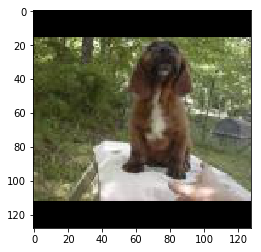

This should be a dog...


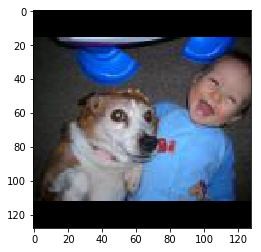

This should be a cat...


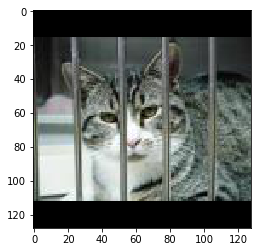

This should be a dog...


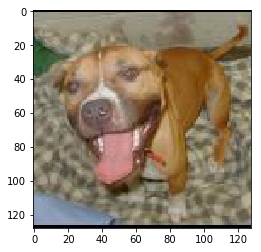

This should be a cat...


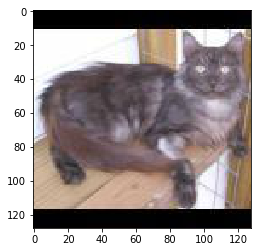

In [54]:
for i in range(5):
    label = y_train[i]
    if label == DOG_LABEL:
        print("This should be a dog...")
        
    elif label == CAT_LABEL:
        print("This should be a cat...")
    
    plt.imshow(X_train[i])
    plt.show()

### We still need to normalize our data, remember that normalization is done with the following formula
![title](normalization.png)

In [55]:
def normalize(raw_data):
    # TODO Figure this out
    # NOTE USE EITHER mean centering or min-max, NOT BOTH
    
    # Min and max values are 0 and 255
    raw_data = raw_data / 255
    
    # Mean centering
    #raw_data = (raw_data - raw_data.mean()) / raw_data.std()
    
    return raw_data


X_train = X_train / 255
X_validation = X_validation / 255
X_test = X_test /  255
#X_train.shape

### Machine learning! (at last!)

Things to do are

* Load VGG16 pretrained model.
* Make sure we do NOT have the latest fully connected layers from VGG16.
* Add our own fully connected layers
* Perform magic :)

In [56]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)

X_train (400, 128, 128, 3)
y_train (400,)


In [57]:
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.initializers import TruncatedNormal


Using TensorFlow backend.


In [58]:
model_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False)


In [91]:
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [92]:
x = model_vgg16.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(1024, activation='relu', kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=None))(x)

y = Dense(1024, activation='relu', kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=None))(x)

# and a fully connected output/classification layer
predictions = Dense(1, 
                    activation='sigmoid', 
                    kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=None))(y)

# create the full network so we can train on it
transfer_model = Model(input=model_vgg16.input, output=predictions)

/home/moriano/dev/tools/anaconda/install/envs/tensorflow35/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [93]:
# We do NOT want to retrain the convolutional layers from vgg16
for layer in model_vgg16.layers:
    layer.trainable = False

In [94]:
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [105]:
transfer_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [106]:
# And fit it...
transfer_history = transfer_model.fit(X_train, y_train,
                                      batch_size=8,
                                      epochs=20,
                                      verbose=1,
                                      validation_data=(X_validation, y_validation))

Train on 196 samples, validate on 48 samples
Epoch 1/20
 88/196 [============>.................] - ETA: 30s - loss: 0.6476 - acc: 0.8636

KeyboardInterrupt: 

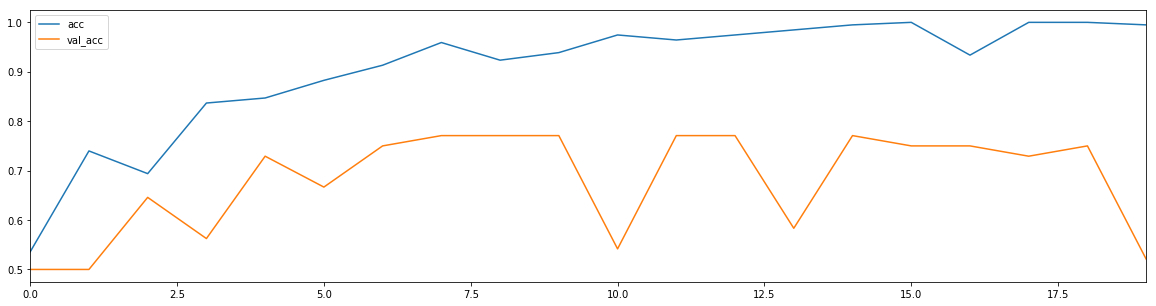

In [103]:
h = pd.DataFrame([transfer_history.history['acc'], transfer_history.history['val_acc']])
h = h.T
h.columns=['acc', 'val_acc']
h.plot(figsize=(20, 5))
plt.show()

In [104]:
transfer_model.evaluate(X_test, y_test)

48/48 [==============================] - 14s 286ms/step


[1.0644621054331462, 0.89583333333333337]

In [45]:
transfer_model.save("model_catsvsdogs_vgg16_20epochs.model")

# Prediction area!!
## We will just load the keras model and use it to predict data

In [59]:
from keras.models import load_model

In [60]:
model = load_model('model_catsvsdogs_vgg16_20epochs.model')

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### We are going to clean the data now.

#### First we load ALL our data, then perform a prediction and we will get the 50 elements with the biggest classification errors... lets see if those are really errors or just bad data

In [241]:
cats, dogs, _ = load_data(load_from=1000, load_to=2000, cleaned_data_dir=CLEANED_DATA_DIR, use_augmented=False)

Done!, first image was dog. 1000 .jpg, last image name was  dog.2000.jpg


In [242]:
cats = np.array(cats)
dogs = np.array(dogs)

dogs.shape

(1001, 128, 128, 3)

In [243]:
cats_normalized = cats / 255
dogs_normalized = dogs / 255

In [239]:
def display_worst_errors(my_model, to_predict, dogs_expected):

    to_predict_normalized = to_predict / 255
    expectations = 1 if dogs_expected == True else 0
    my_predictions = my_model.predict(to_predict_normalized, verbose=1)
    
    my_predictions_df = pd.DataFrame(my_predictions, columns=['dog', 'cat']) 
    column_to_use = "dog" if dogs_expected else "cat"
    errors = my_predictions_df[my_predictions_df[column_to_use] < 0.75]
    
    errors.sort_values(by=column_to_use, inplace=True)
    
    for index, row in errors.iterrows():
        print("Image at index", index, "is predicted as ", str(row))

        my_plot = pd.DataFrame(row).T
        fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(to_predict[index])
        ax2 = fig.add_subplot(1,2,2)

        ax2.imshow(to_predict[index])


        my_plot.plot(kind='bar', title="image would be %s.%d.jpg" % (column_to_use, index))


        plt.show()

    

1001/1001 [==============================] - 420s 419ms/step


/home/moriano/dev/tools/anaconda/install/envs/tensorflow35/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Image at index 387 is predicted as  dog    0.001069
cat    0.998931
Name: 387, dtype: float32


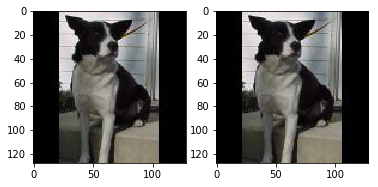

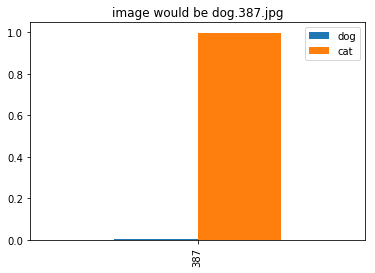

Image at index 681 is predicted as  dog    0.012627
cat    0.987374
Name: 681, dtype: float32


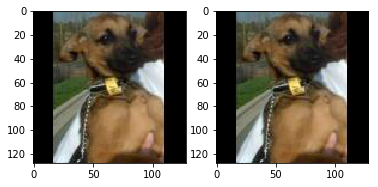

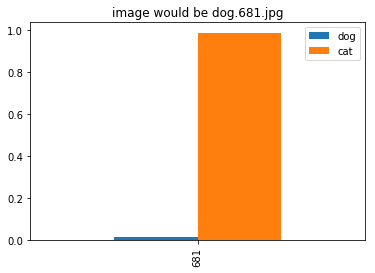

Image at index 194 is predicted as  dog    0.040771
cat    0.959229
Name: 194, dtype: float32


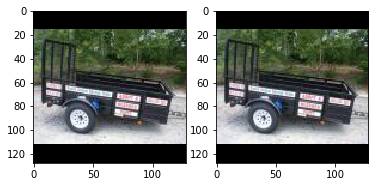

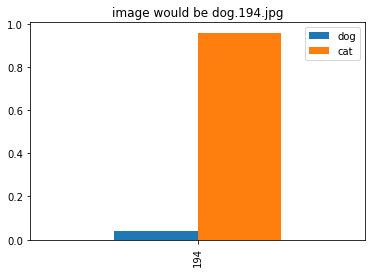

Image at index 929 is predicted as  dog    0.041642
cat    0.958358
Name: 929, dtype: float32


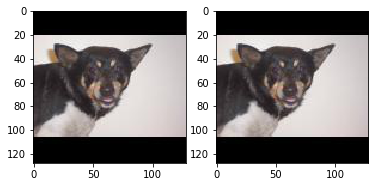

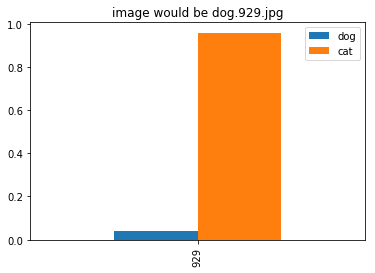

Image at index 170 is predicted as  dog    0.043851
cat    0.956149
Name: 170, dtype: float32


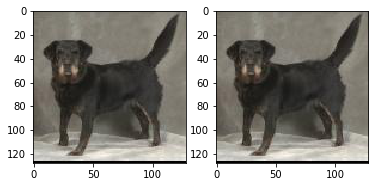

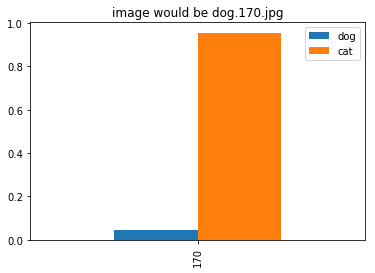

Image at index 864 is predicted as  dog    0.078135
cat    0.921865
Name: 864, dtype: float32


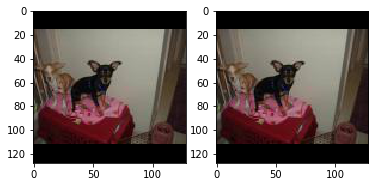

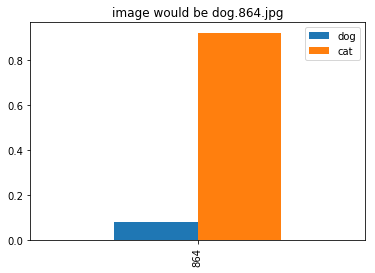

Image at index 625 is predicted as  dog    0.080763
cat    0.919237
Name: 625, dtype: float32


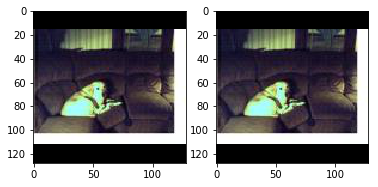

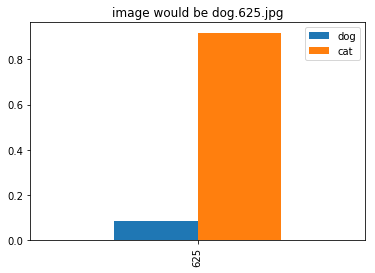

Image at index 209 is predicted as  dog    0.099788
cat    0.900212
Name: 209, dtype: float32


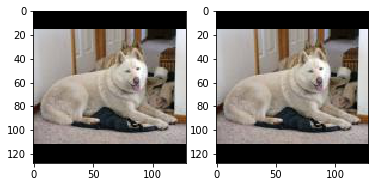

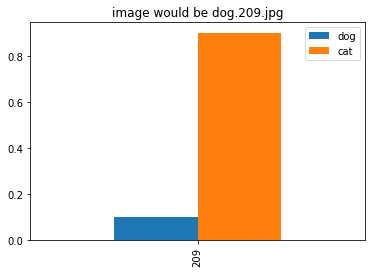

Image at index 478 is predicted as  dog    0.10451
cat    0.89549
Name: 478, dtype: float32


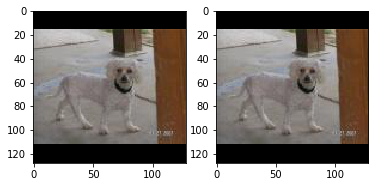

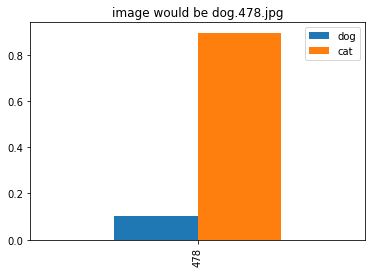

Image at index 374 is predicted as  dog    0.112883
cat    0.887117
Name: 374, dtype: float32


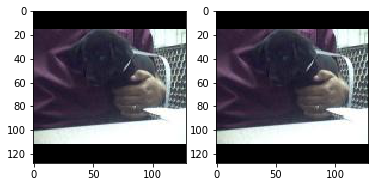

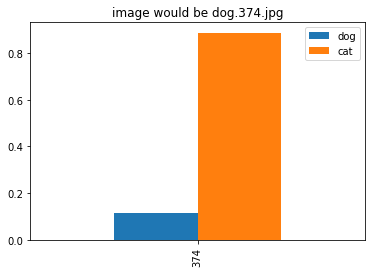

Image at index 788 is predicted as  dog    0.113134
cat    0.886866
Name: 788, dtype: float32


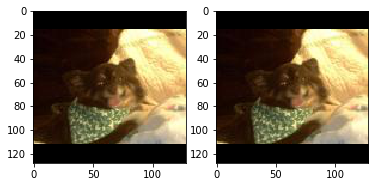

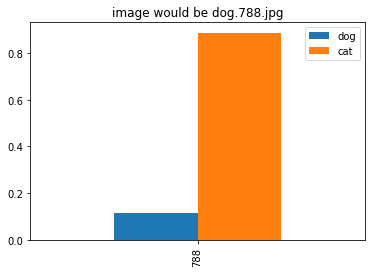

Image at index 406 is predicted as  dog    0.122362
cat    0.877638
Name: 406, dtype: float32


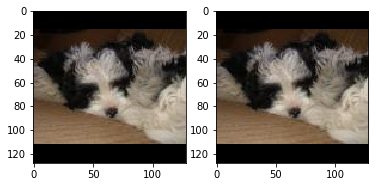

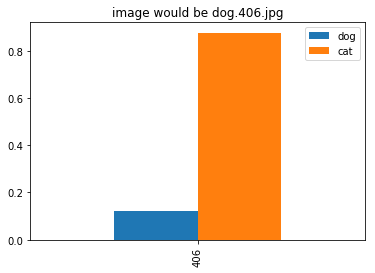

Image at index 196 is predicted as  dog    0.149912
cat    0.850088
Name: 196, dtype: float32


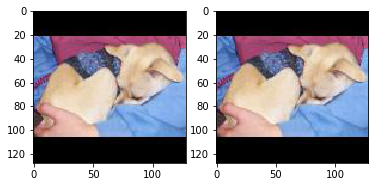

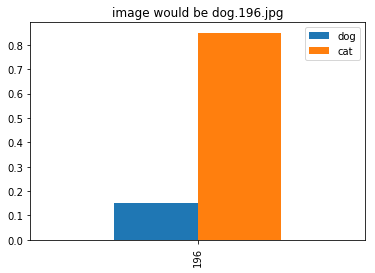

Image at index 16 is predicted as  dog    0.15092
cat    0.84908
Name: 16, dtype: float32


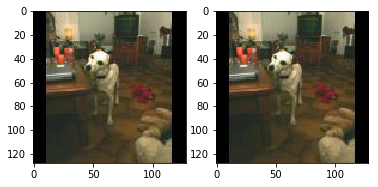

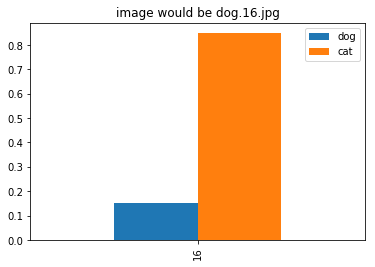

Image at index 884 is predicted as  dog    0.151552
cat    0.848448
Name: 884, dtype: float32


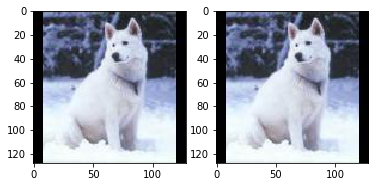

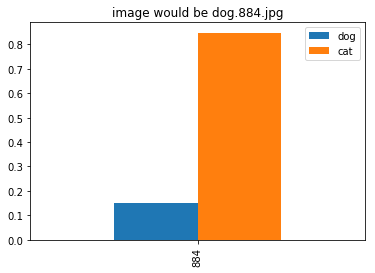

Image at index 32 is predicted as  dog    0.161605
cat    0.838395
Name: 32, dtype: float32


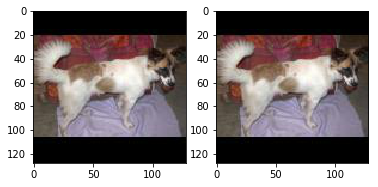

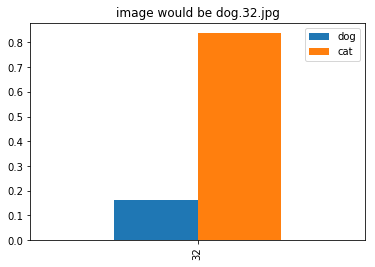

Image at index 541 is predicted as  dog    0.173727
cat    0.826273
Name: 541, dtype: float32


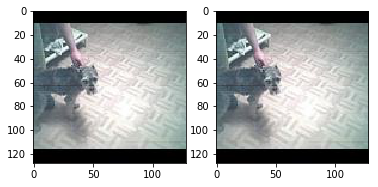

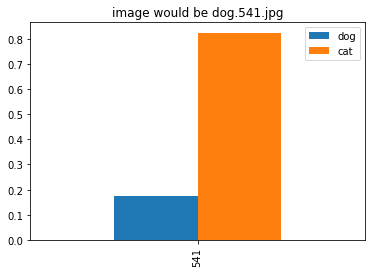

Image at index 497 is predicted as  dog    0.180233
cat    0.819767
Name: 497, dtype: float32


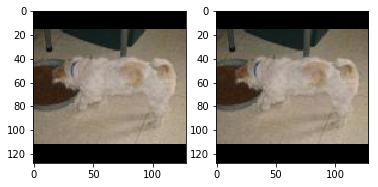

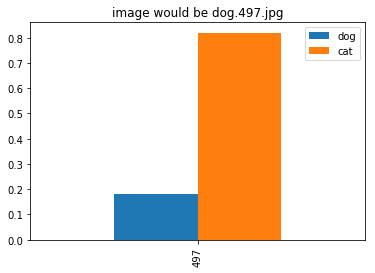

Image at index 388 is predicted as  dog    0.195145
cat    0.804855
Name: 388, dtype: float32


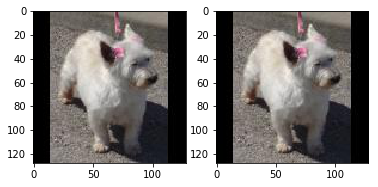

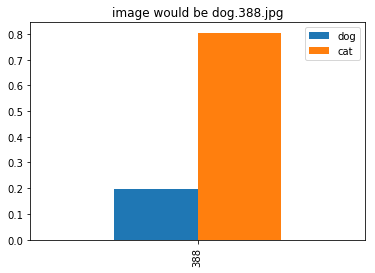

Image at index 651 is predicted as  dog    0.196483
cat    0.803517
Name: 651, dtype: float32


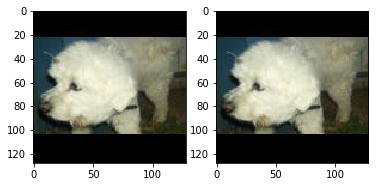

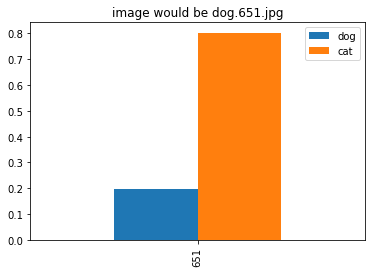

Image at index 142 is predicted as  dog    0.266328
cat    0.733672
Name: 142, dtype: float32


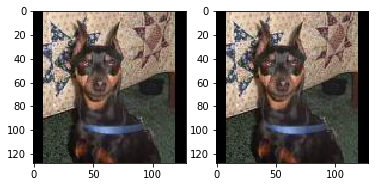

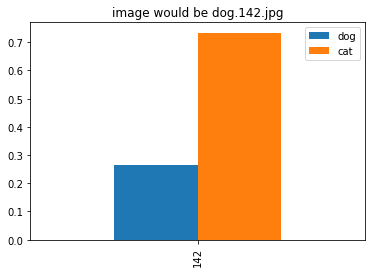

Image at index 592 is predicted as  dog    0.267664
cat    0.732336
Name: 592, dtype: float32


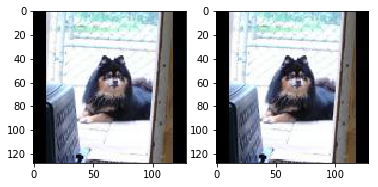

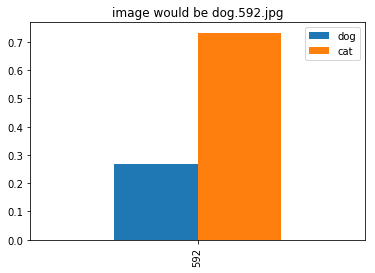

Image at index 765 is predicted as  dog    0.279376
cat    0.720624
Name: 765, dtype: float32


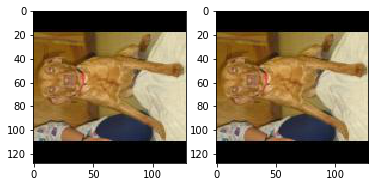

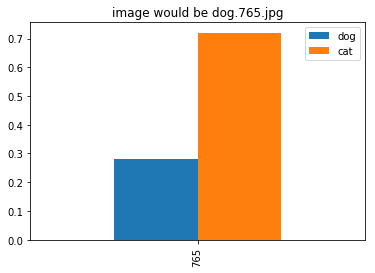

Image at index 993 is predicted as  dog    0.296702
cat    0.703298
Name: 993, dtype: float32


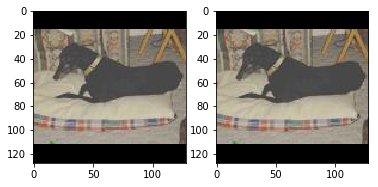

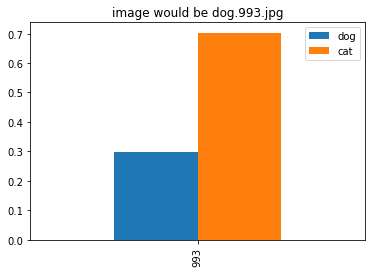

Image at index 122 is predicted as  dog    0.332314
cat    0.667686
Name: 122, dtype: float32


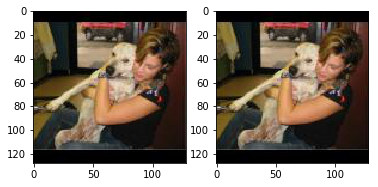

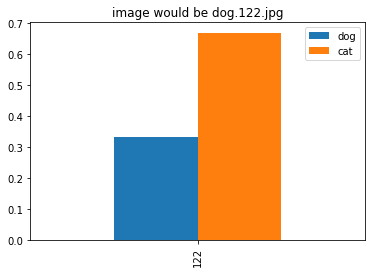

Image at index 544 is predicted as  dog    0.348303
cat    0.651697
Name: 544, dtype: float32


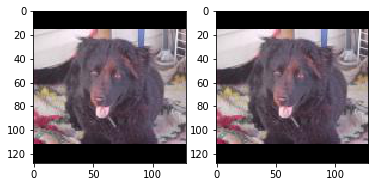

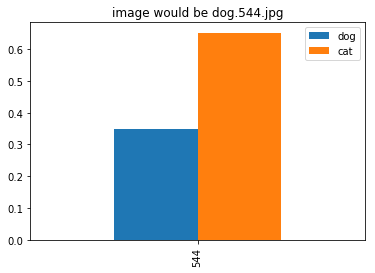

Image at index 953 is predicted as  dog    0.349115
cat    0.650885
Name: 953, dtype: float32


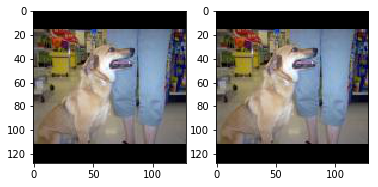

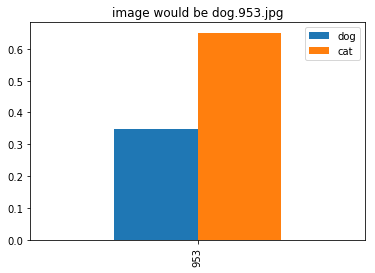

Image at index 960 is predicted as  dog    0.363429
cat    0.636571
Name: 960, dtype: float32


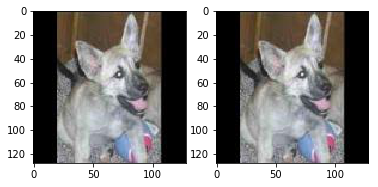

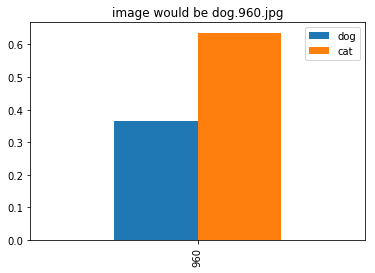

Image at index 855 is predicted as  dog    0.386643
cat    0.613357
Name: 855, dtype: float32


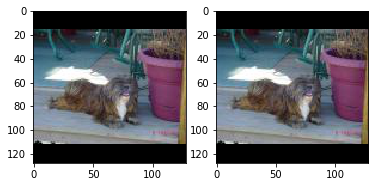

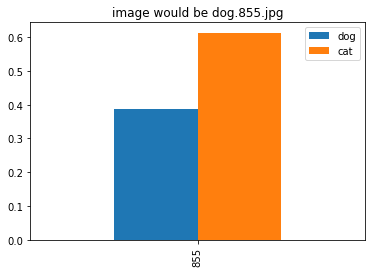

Image at index 994 is predicted as  dog    0.391238
cat    0.608762
Name: 994, dtype: float32


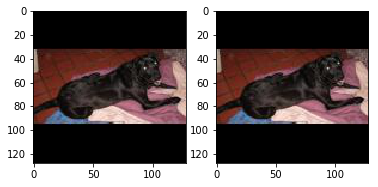

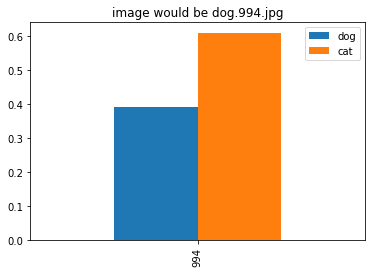

Image at index 666 is predicted as  dog    0.398291
cat    0.601709
Name: 666, dtype: float32


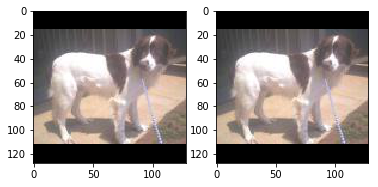

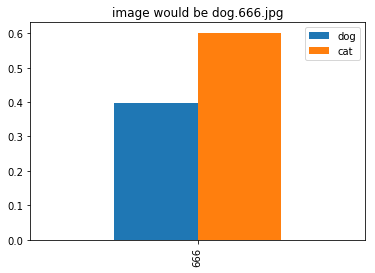

Image at index 289 is predicted as  dog    0.400038
cat    0.599962
Name: 289, dtype: float32


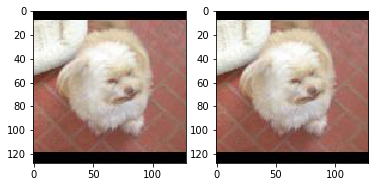

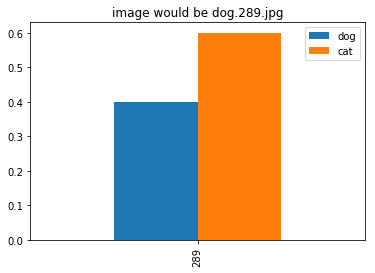

Image at index 1 is predicted as  dog    0.404397
cat    0.595603
Name: 1, dtype: float32


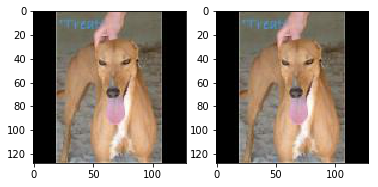

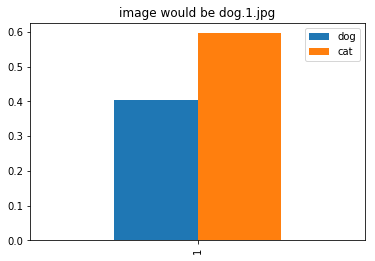

Image at index 959 is predicted as  dog    0.408002
cat    0.591998
Name: 959, dtype: float32


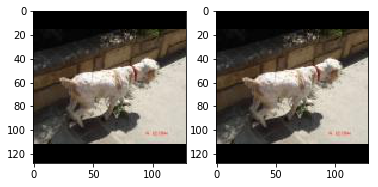

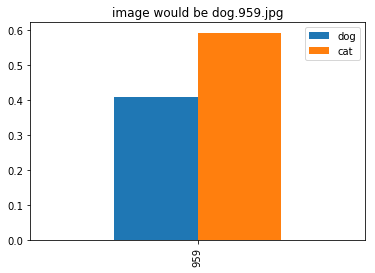

Image at index 522 is predicted as  dog    0.414644
cat    0.585356
Name: 522, dtype: float32


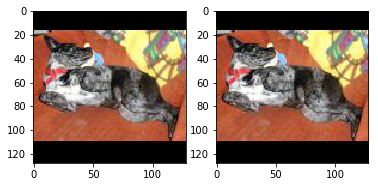

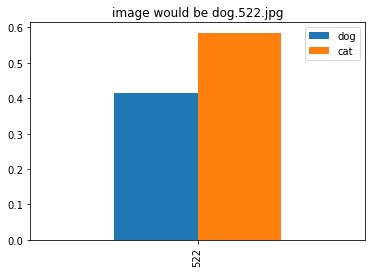

Image at index 380 is predicted as  dog    0.415426
cat    0.584574
Name: 380, dtype: float32


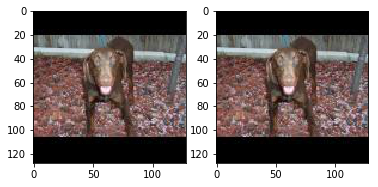

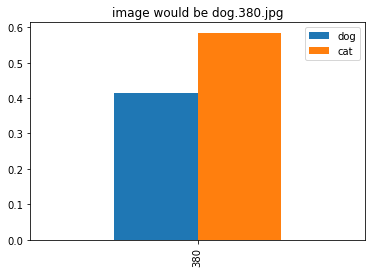

Image at index 978 is predicted as  dog    0.415938
cat    0.584062
Name: 978, dtype: float32


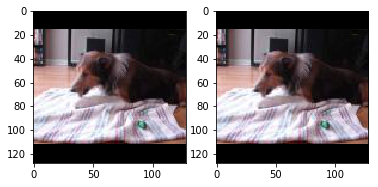

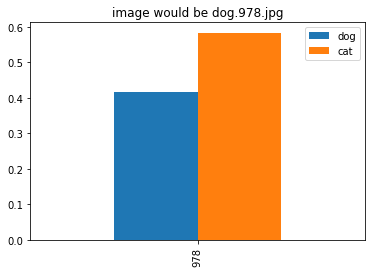

Image at index 185 is predicted as  dog    0.41819
cat    0.58181
Name: 185, dtype: float32


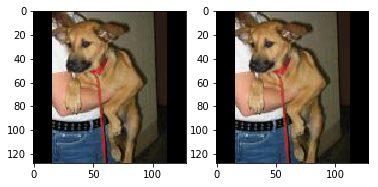

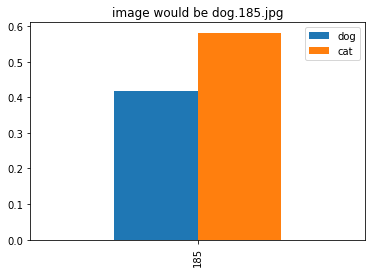

Image at index 257 is predicted as  dog    0.433765
cat    0.566235
Name: 257, dtype: float32


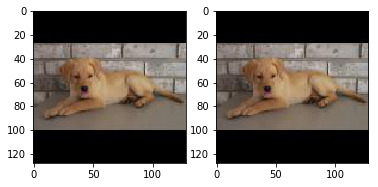

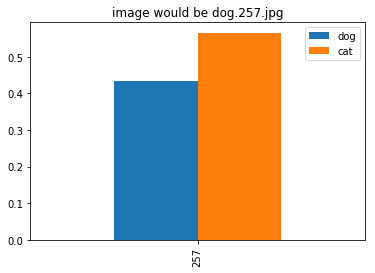

Image at index 103 is predicted as  dog    0.435347
cat    0.564653
Name: 103, dtype: float32


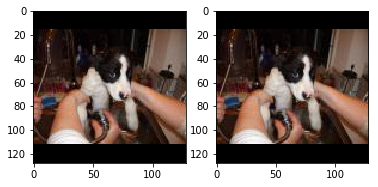

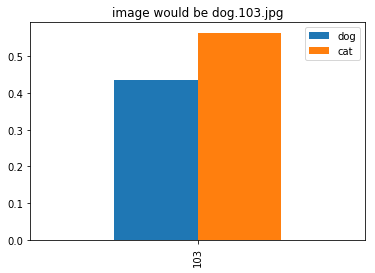

Image at index 591 is predicted as  dog    0.451838
cat    0.548162
Name: 591, dtype: float32


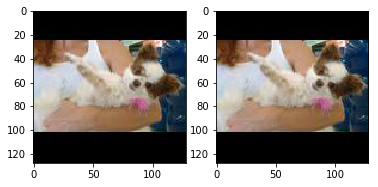

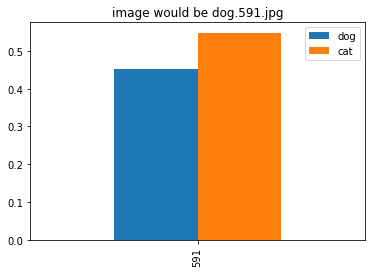

Image at index 509 is predicted as  dog    0.455531
cat    0.544469
Name: 509, dtype: float32


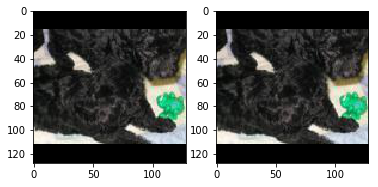

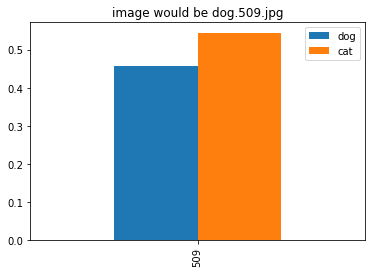

Image at index 79 is predicted as  dog    0.457659
cat    0.542341
Name: 79, dtype: float32


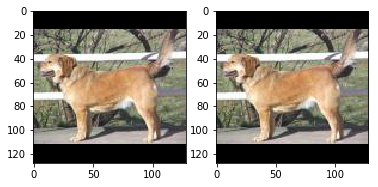

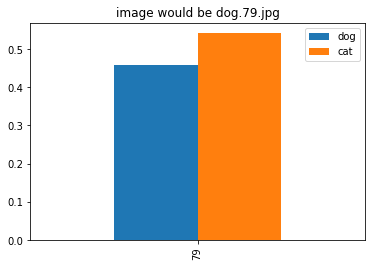

Image at index 302 is predicted as  dog    0.471197
cat    0.528803
Name: 302, dtype: float32


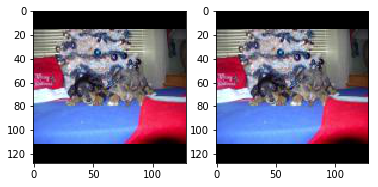

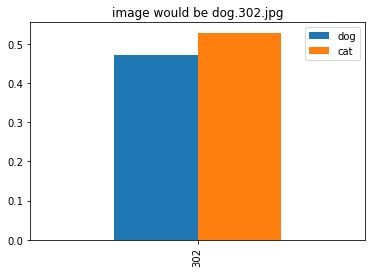

Image at index 589 is predicted as  dog    0.472056
cat    0.527944
Name: 589, dtype: float32


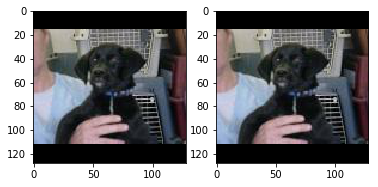

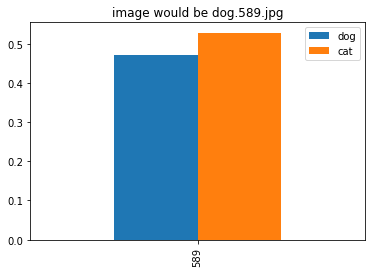

Image at index 181 is predicted as  dog    0.504514
cat    0.495486
Name: 181, dtype: float32


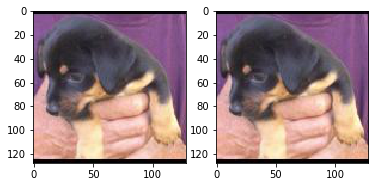

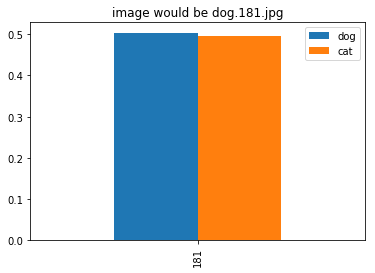

Image at index 413 is predicted as  dog    0.506496
cat    0.493504
Name: 413, dtype: float32


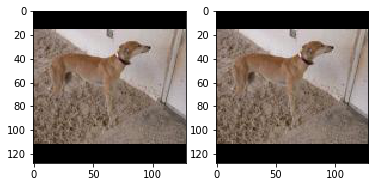

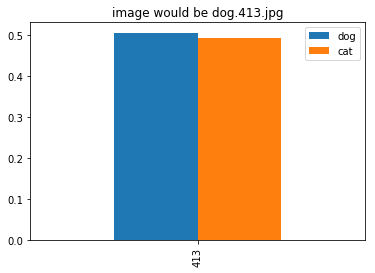

Image at index 176 is predicted as  dog    0.517219
cat    0.482781
Name: 176, dtype: float32


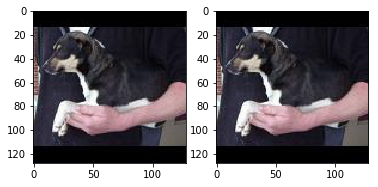

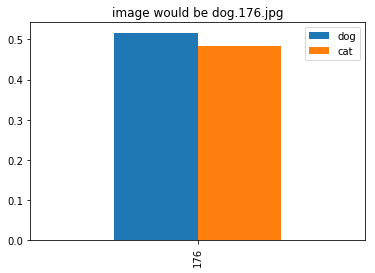

Image at index 796 is predicted as  dog    0.522696
cat    0.477303
Name: 796, dtype: float32


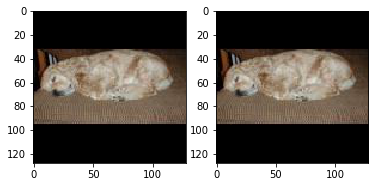

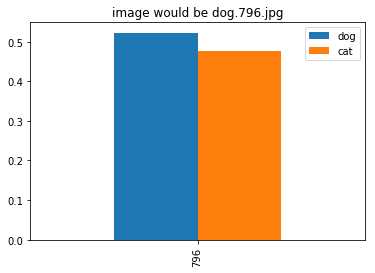

Image at index 751 is predicted as  dog    0.538462
cat    0.461538
Name: 751, dtype: float32


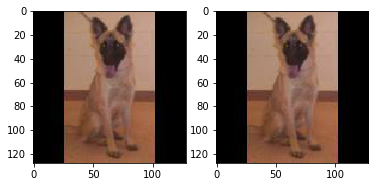

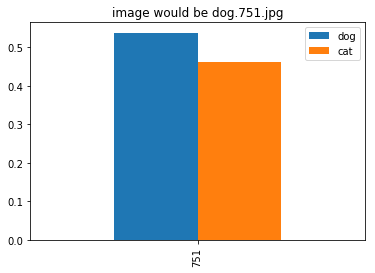

Image at index 554 is predicted as  dog    0.542291
cat    0.457709
Name: 554, dtype: float32


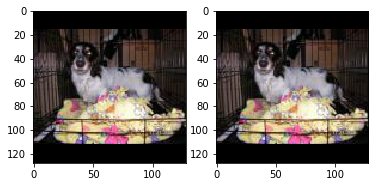

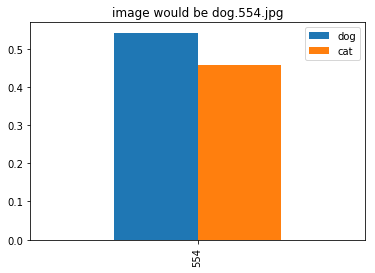

Image at index 499 is predicted as  dog    0.558918
cat    0.441082
Name: 499, dtype: float32


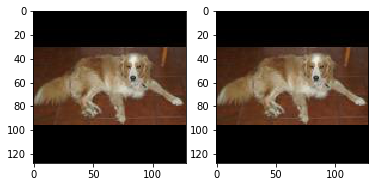

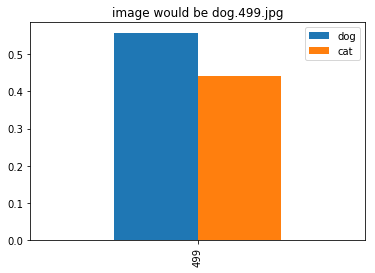

Image at index 749 is predicted as  dog    0.559689
cat    0.440311
Name: 749, dtype: float32


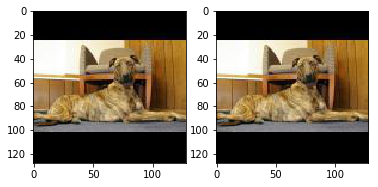

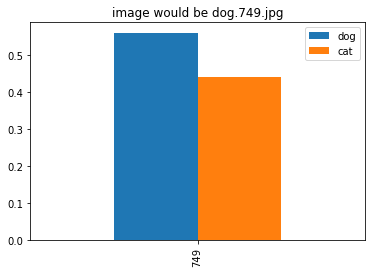

Image at index 853 is predicted as  dog    0.561903
cat    0.438097
Name: 853, dtype: float32


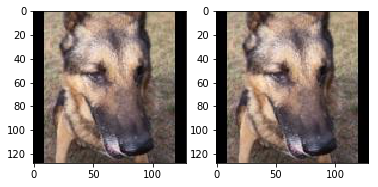

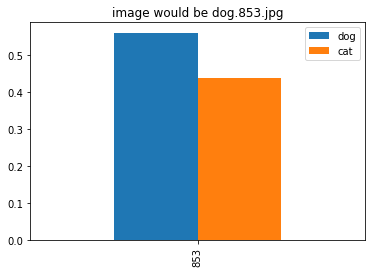

Image at index 928 is predicted as  dog    0.563944
cat    0.436056
Name: 928, dtype: float32


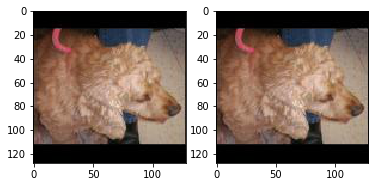

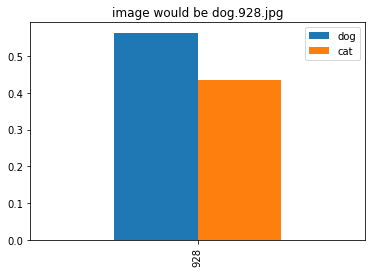

Image at index 240 is predicted as  dog    0.572747
cat    0.427253
Name: 240, dtype: float32


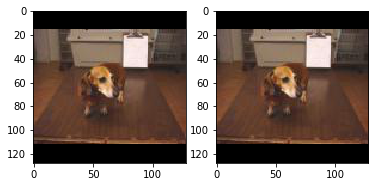

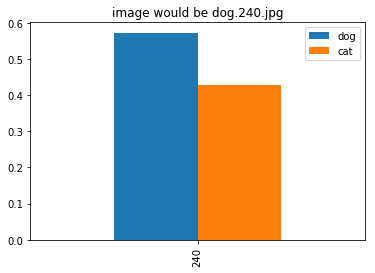

Image at index 417 is predicted as  dog    0.573771
cat    0.426229
Name: 417, dtype: float32


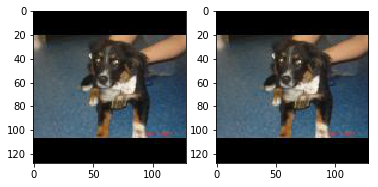

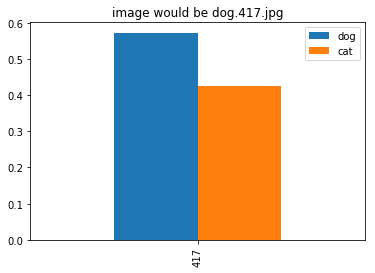

Image at index 985 is predicted as  dog    0.577024
cat    0.422976
Name: 985, dtype: float32


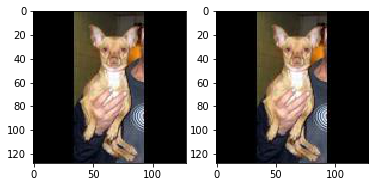

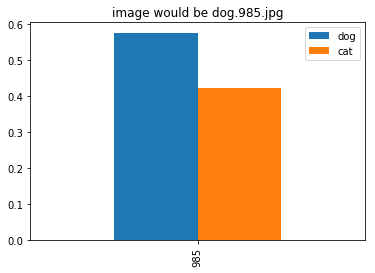

Image at index 184 is predicted as  dog    0.596851
cat    0.403149
Name: 184, dtype: float32


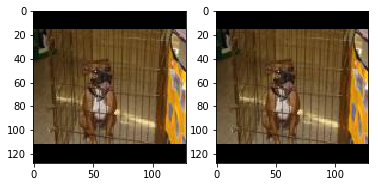

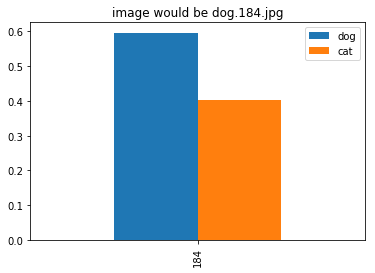

Image at index 903 is predicted as  dog    0.610435
cat    0.389565
Name: 903, dtype: float32


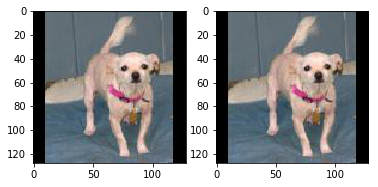

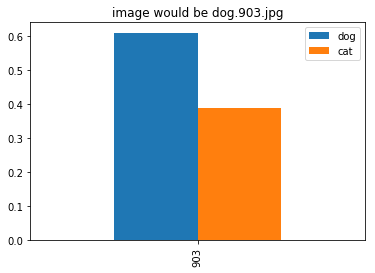

Image at index 251 is predicted as  dog    0.61078
cat    0.38922
Name: 251, dtype: float32


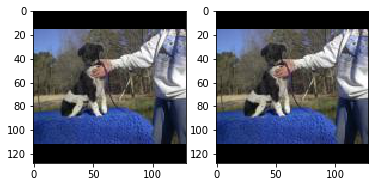

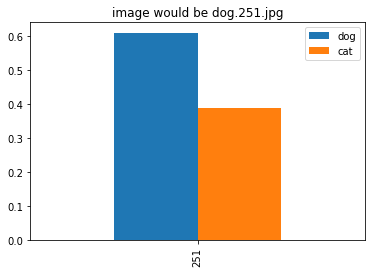

Image at index 396 is predicted as  dog    0.6112
cat    0.3888
Name: 396, dtype: float32


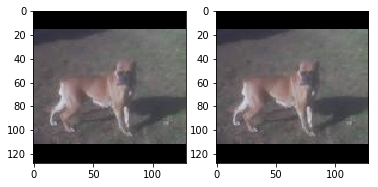

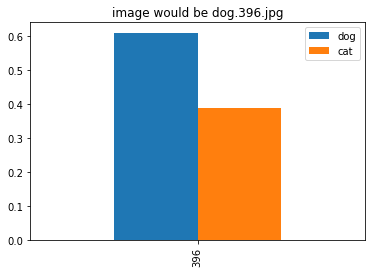

Image at index 7 is predicted as  dog    0.612703
cat    0.387297
Name: 7, dtype: float32


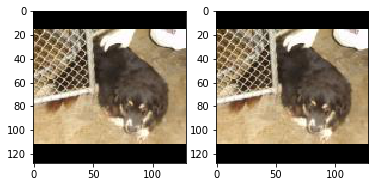

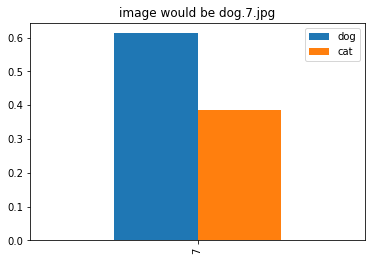

Image at index 130 is predicted as  dog    0.617796
cat    0.382204
Name: 130, dtype: float32


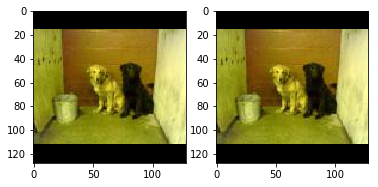

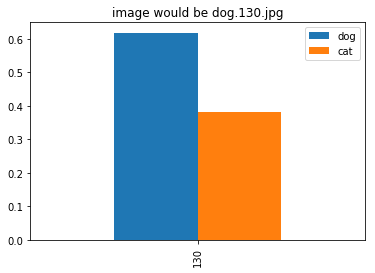

Image at index 657 is predicted as  dog    0.623848
cat    0.376152
Name: 657, dtype: float32


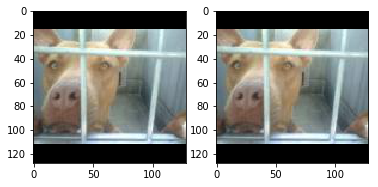

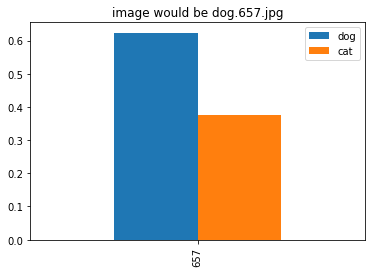

Image at index 896 is predicted as  dog    0.624714
cat    0.375286
Name: 896, dtype: float32


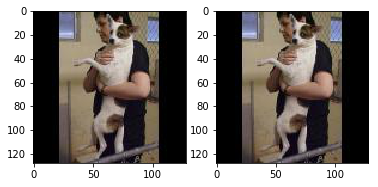

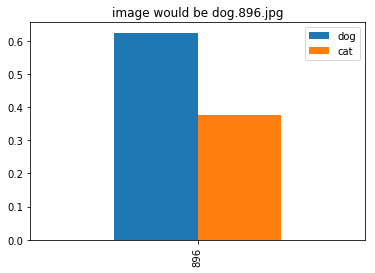

Image at index 584 is predicted as  dog    0.629327
cat    0.370673
Name: 584, dtype: float32


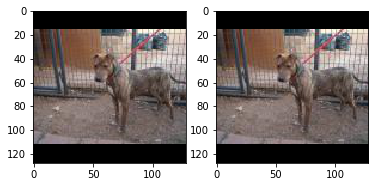

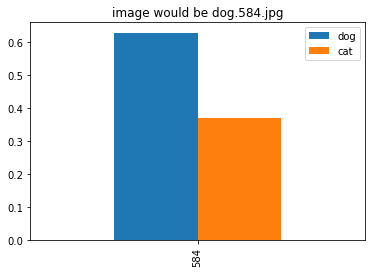

Image at index 254 is predicted as  dog    0.638616
cat    0.361384
Name: 254, dtype: float32


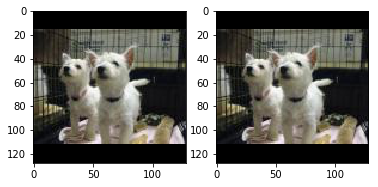

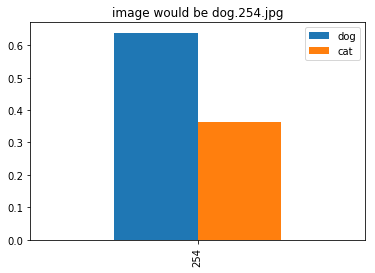

Image at index 668 is predicted as  dog    0.642054
cat    0.357946
Name: 668, dtype: float32


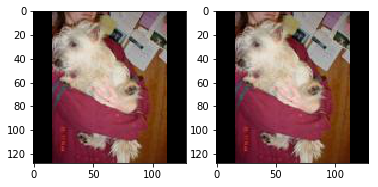

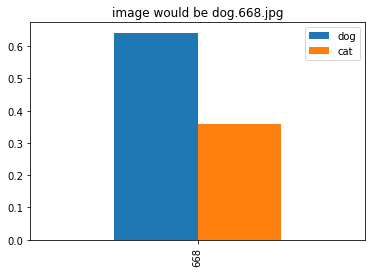

Image at index 373 is predicted as  dog    0.673457
cat    0.326543
Name: 373, dtype: float32


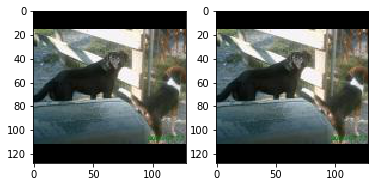

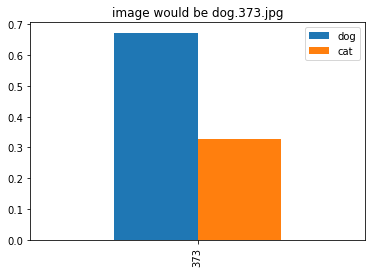

Image at index 885 is predicted as  dog    0.677829
cat    0.322170
Name: 885, dtype: float32


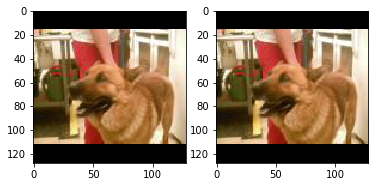

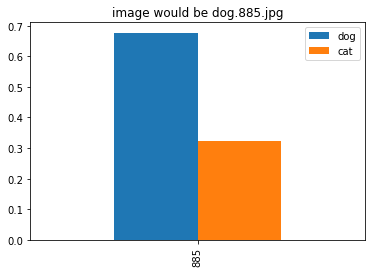

Image at index 163 is predicted as  dog    0.689596
cat    0.310404
Name: 163, dtype: float32


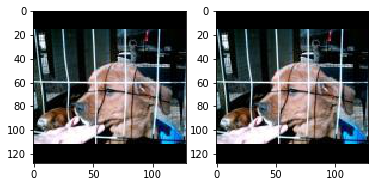

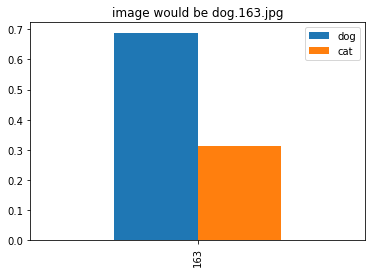

Image at index 199 is predicted as  dog    0.695879
cat    0.304121
Name: 199, dtype: float32


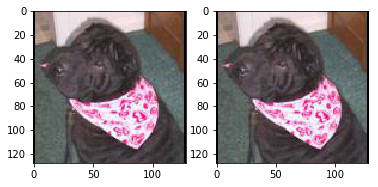

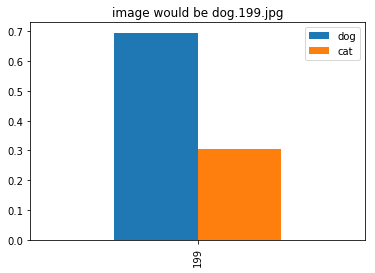

Image at index 362 is predicted as  dog    0.7017
cat    0.2983
Name: 362, dtype: float32


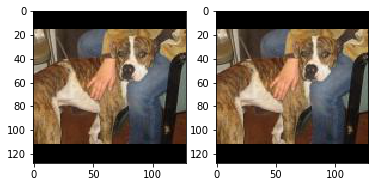

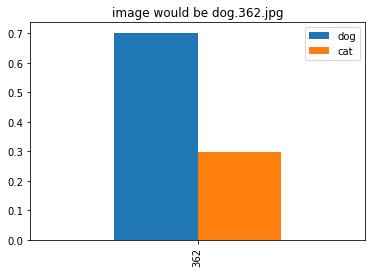

Image at index 635 is predicted as  dog    0.707002
cat    0.292998
Name: 635, dtype: float32


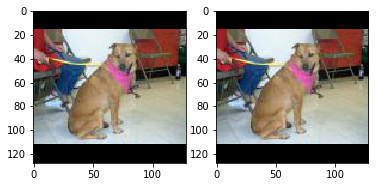

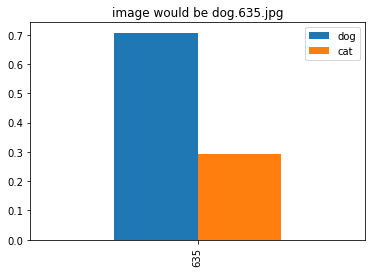

Image at index 434 is predicted as  dog    0.708237
cat    0.291763
Name: 434, dtype: float32


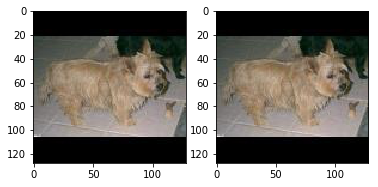

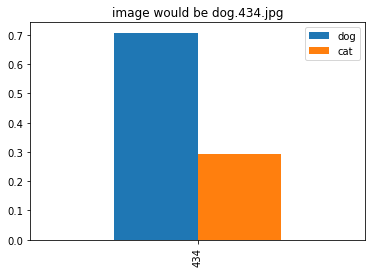

Image at index 242 is predicted as  dog    0.717223
cat    0.282777
Name: 242, dtype: float32


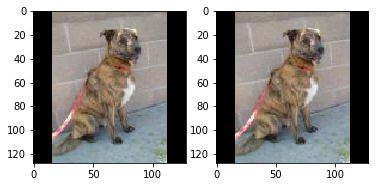

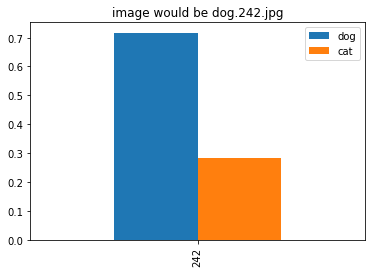

Image at index 872 is predicted as  dog    0.721413
cat    0.278587
Name: 872, dtype: float32


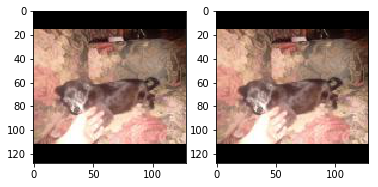

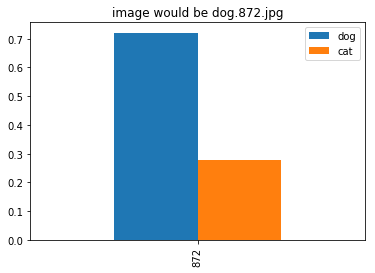

Image at index 648 is predicted as  dog    0.731895
cat    0.268105
Name: 648, dtype: float32


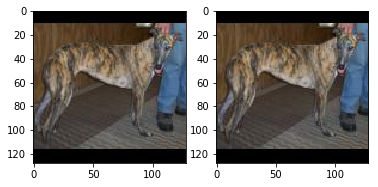

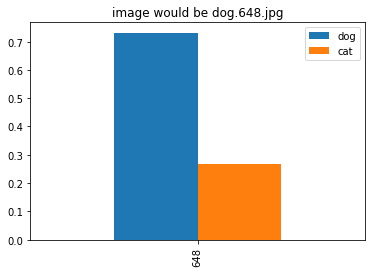

Image at index 649 is predicted as  dog    0.741444
cat    0.258556
Name: 649, dtype: float32


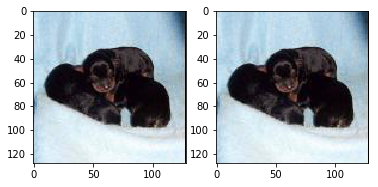

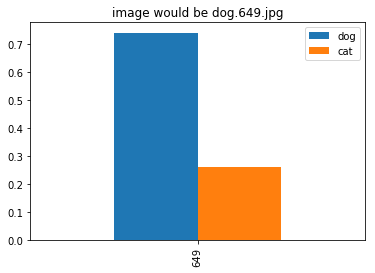

Image at index 534 is predicted as  dog    0.742968
cat    0.257032
Name: 534, dtype: float32


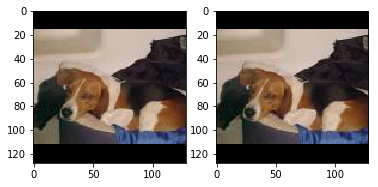

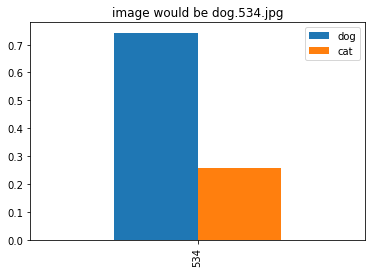

In [ ]:
display_worst_errors(model, dogs, dogs_expected=True)

In [ ]:
display_worst_errors(model, cats, dogs_expected=False)

 288/1001 [=======>......................] - ETA: 5:34

In [216]:
row.values

array([ 0.5381043 ,  0.46189573], dtype=float32)

In [145]:
my_plot

dog       cat
46  0.649338  0.350662

In [108]:
my_predictions_df[my_predictions_df["dog"] < 0.75]

dog       cat
21  0.452954  0.547046
18  0.602924  0.397076
46  0.649338  0.350662

In [73]:
cats_predictions

array([[  6.40784208e-08,   9.99999881e-01],
       [  2.61759170e-09,   1.00000000e+00],
       [  8.62400222e-04,   9.99137521e-01],
       [  2.13728566e-03,   9.97862756e-01],
       [  2.05080677e-02,   9.79491949e-01],
       [  4.82688785e-01,   5.17311275e-01],
       [  1.05092468e-09,   1.00000000e+00],
       [  2.94281682e-03,   9.97057199e-01],
       [  1.05217569e-01,   8.94782484e-01],
       [  8.19130801e-14,   1.00000000e+00],
       [  6.84569478e-02,   9.31542993e-01],
       [  3.91092934e-02,   9.60890770e-01],
       [  1.65980518e-01,   8.34019482e-01],
       [  1.47301796e-16,   1.00000000e+00],
       [  2.29669432e-03,   9.97703373e-01],
       [  2.00114921e-02,   9.79988575e-01],
       [  7.87162164e-04,   9.99212861e-01],
       [  1.07449569e-06,   9.99998927e-01],
       [  3.11097771e-01,   6.88902199e-01],
       [  1.13072349e-06,   9.99998927e-01],
       [  5.89089992e-04,   9.99410868e-01],
       [  4.36581492e-01,   5.63418508e-01],
       [  

In [72]:
dogs_predictions = model.predict(dogs_normalized, verbose=1)

50/50 [==============================] - 9s 173ms/step


In [74]:
dogs_predictions

array([[  1.00000000e+00,   4.31817559e-12],
       [  9.95271504e-01,   4.72845649e-03],
       [  9.34369504e-01,   6.56304881e-02],
       [  1.00000000e+00,   0.00000000e+00],
       [  9.99821126e-01,   1.78894697e-04],
       [  9.85173345e-01,   1.48267038e-02],
       [  9.94435668e-01,   5.56435250e-03],
       [  1.00000000e+00,   2.28047572e-20],
       [  1.00000000e+00,   2.94170370e-19],
       [  1.00000000e+00,   1.70783049e-32],
       [  1.00000000e+00,   4.53023716e-08],
       [  9.35910821e-01,   6.40892237e-02],
       [  1.00000000e+00,   1.19571810e-08],
       [  9.99999881e-01,   1.25263398e-07],
       [  9.31027293e-01,   6.89727068e-02],
       [  1.00000000e+00,   1.54746482e-09],
       [  9.72427726e-01,   2.75722370e-02],
       [  6.02923810e-01,   3.97076219e-01],
       [  9.44001317e-01,   5.59986494e-02],
       [  9.99999166e-01,   7.78036110e-07],
       [  4.52953637e-01,   5.47046423e-01],
       [  9.99997973e-01,   2.08162169e-06],
       [  

## Now, we load the test data and then resize it, normalize it and produce the output

In [ ]:
convert_images(limit=None, data_dir="data/test/", cleaned_data_dir="data/test/cleaned/")

In [ ]:
_, _, X_test_very_raw = load_data(cleaned_data_dir="data/test/cleaned/", limit=50)

In [ ]:
len(X_test_very_raw)

In [ ]:
X_test_raw = np.array(X_test_very_raw)

In [ ]:
X_test = normalize(X_test_raw)

In [ ]:
results = model.predict(X_test, verbose=1)

In [ ]:
results.shape

In [ ]:
PILImage.fromarray(X_test_very_raw[0])

In [ ]:
for idx in range(0, 20):
    plt.imshow(X_test_very_raw[idx])
    plt.show()
    pred = pd.DataFrame(results[idx, ], ["DOG", "CAT"])
    pred.plot(kind="bar", legend=False, title="prediction")    
    plt.show()
    print("\n\n\n\n")

In [ ]:
results[2,]